In [3]:
import numpy as np
import pickle
from funcy                     import *
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers        import l2
from keras.utils               import plot_model
import keras.layers as kl


import psutil
import keras

# monitoring CPU status
class CPU_usage(keras.callbacks.Callback):
    def on_epoch_begin(self, batch, logs={}):
        memo = sum([i.memory_percent() for i in psutil.process_iter()])
        print('CPU:%0.1f'%psutil.cpu_percent(),'memo:%0.1f'%memo)
        
cpu_usage = CPU_usage()


# LossHistory recorder
import pickle
from matplotlib import pyplot as  plt
class LossHistory(keras.callbacks.Callback):
    def __init__(self,name):
        super(keras.callbacks.Callback, self).__init__()
        self.logs = {'loss':[],'acc':[],'val_loss':[],'val_acc':[]}
        self.name = name
        
    def on_epoch_end(self, epoch,logs={}):
        for i in self.logs.keys():
            self.logs[i].append(logs.get(i))
        self.tofile()
        
    def tofile(self,):
        with open(self.name+'.pickle', 'wb') as f:
            pickle.dump(self.logs, f)
    
    def readfile(self,):
        with open(self.name+'.pickle', 'rb') as f:
            self.logs = pickle.load(f)
            
    def plot_history(self,):
        plt.plot(self.logs['acc'], marker='.');plt.plot(self.logs['val_acc'], marker='.')
        plt.title('model accuracy');plt.xlabel('epoch');plt.ylabel('accuracy')
        plt.grid();plt.legend(['acc', 'val_acc'], loc='lower right'); plt.show()

        plt.plot(self.logs['loss'], marker='.');plt.plot(self.logs['val_loss'], marker='.')
        plt.title('model loss');plt.xlabel('epoch');plt.ylabel('loss')
        plt.grid();plt.legend(['loss', 'val_loss'], loc='lower right');plt.show()

In [4]:
import keras
from keras import backend as K
import tensorflow as tf


# basic configs
weight_decay = 0.0005 
use_bias = False
weight_init="he_normal" 
padding = 'same'
L2 = keras.regularizers.l2(weight_decay)
conv_config = {'padding':padding,
               'kernel_initializer':weight_init,
               'kernel_regularizer':L2,
               'use_bias':use_bias}

# insuring image data channel is at last axis 
keras.backend.image_data_format()
# keras.backend..set_image_data_format('channels_first')

'channels_last'

In [3]:
# Utility functions.

def ljuxt(*fs):  
    return rcompose(juxt(*fs), list)

def bn():return BatchNormalization()

def relu():return Activation('relu')

def conv(filter_size, kernel_size, stride_size=1):
    return Conv2D(filter_size, kernel_size=kernel_size,strides=stride_size, **conv_config)

def conv3(filter_size):return conv(filter_size, kernel_size=(3,3), stride_size=1)
def conv1(filter_size):return conv(filter_size, kernel_size=(1,1), stride_size=1)

def add():return Add()

def GlobalAvgPool():return GlobalAveragePooling2D()

def avgPool(pool_size=2,strides=2):return kl.AveragePooling2D(pool_size=pool_size,strides=strides)

def dense(unit_size, activation):
    return Dense(unit_size, activation=activation, kernel_regularizer=L2)  

# original layer which is pad the channel size with zeros matrix, 
# ex. padding (None,28,28,1) 2 zeros channels as (None,28,28,3)
class zeroPad(keras.engine.topology.Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        self.l = None
        super(zeroPad, self).__init__(**kwargs)

    def build(self, input_shape):
        super(zeroPad, self).build(input_shape)

    def call(self, x):
        x_shape = x.shape.as_list()
        if self.output_dim == x_shape[-1]:
            return x
        if self.l is None:
            padding = self.output_dim//x_shape[-1]
            self.l = [x] + [kl.K.zeros_like(x) for i in range(padding-1)]
            self.l +=  [kl.K.zeros_like(x)[:,:,:,:self.output_dim - padding*x_shape[-1]] ]
        return kl.concatenate(self.l)

    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[1],input_shape[2], self.output_dim)

# ================================================================================================================
# resnet has head part , residual part and tail part, 

# residual part contains residual blocks
# evey residual block contains residual units

# residual unit has 4 types
# type 1 : down sample     , up dimension
# type 2 : not down sample , up dimension
# type 3 : down sample     , not up dimension
# type 4 : not down sample , not up dimension

# To down sample,  we have 2 ways : 1x1 conv and pooling.
# To up dimension, we have 2 ways : 1x1 conv and zeroPad.

# usually, the first unit at a block works at down sample. The next units work at up dimension.

#  cfg = {
#       [18]  = {{2, 2, 2, 2}, 512, basicblock}, 
#       18 layers , {2, 2, 2, 2} is residual part's residual units' numbers. Out dim is 512.

#       [34]  = {{3, 4, 6, 3}, 512, basicblock},
#       [50]  = {{3, 4, 6, 3}, 2048, bottleneck},
#       [101] = {{3, 4, 23, 3}, 2048, bottleneck},
#       [152] = {{3, 8, 36, 3}, 2048, bottleneck},
#       [200] = {{3, 24, 36, 3}, 2048, bottleneck},
#    }

def first_residual_unit(filter_size, stride_size, avg_pooling=False):
    
 # define shortcut processes. To down sample, we have 2 ways : 1x1 conv and pooling.
    if avg_pooling and stride_size>1:
        shortcut = [average_pooling(stride_size,stride_size),zeroPad(filter_size)]
    else:
        shortcut = [conv(filter_size, 1, stride_size)]

# this code has a very strange style, but very brevity 
    return rcompose(#input
                    batch_normalization(),# ｜ do bn
                    relu(),               # ｜ do relu 
                                          # ーーーーーーーーーーーーーーーーーーーーーーー seperate into 2 branch
                    ljuxt(rcompose(conv(filter_size, 3, stride_size),#  ◀︎ー｜　　｜
                                   batch_normalization(),#              　　　　　｜
                                   relu(),#    　  　　　　　　           　　　　　｜
                                   conv3(filter_size)),#    　　　　　　　　　　　　｜
                                             #    　　　　　　　　　　         　　｜
                          rcompose(*shortcut)#   ◀︎ーーーーーーーーーーーーーーーーー｜ do shortcut processes
                          ),
                    # 2 branch'results will be combined into a list
                    add())# do add 

# basic type pre-activation residual unit
def residual_unit(filter_size):
    return rcompose(#input
                    # ーーーーーーーーーーーーーーーーーーーーーーーーーーーーー seperate into 2 branch
                    ljuxt(rcompose(batch_normalization(),#  ◀︎ー｜　 　｜
                                   relu(), #                  　  　  ｜
                                   conv3(filter_size),#         　   ｜
                                   batch_normalization(),#          ｜
                                   relu(),#                         ｜
                                   conv3(filter_size)),#           ｜
                          #                                        ｜
                          identity),# do nothing, return itself.◀︎ー
                    # 2 branch'results will be combined into a list
                    add())

# bottleneck type pre-activation residual unit
def residual_bottleneck_unit(filter_size):
    return rcompose(ljuxt(rcompose(batch_normalization(),
                                   relu(),
                                   conv1(filter_size//4),
                                   batch_normalization(),
                                   relu(),
                                   conv3(filter_size//4),
                                   batch_normalization(),
                                   relu(),
                                   conv1(filter_size)),
                           identity),
                    add())

def pyramidal_residual_bottleneck_unit(filter_size):
    filter_size = next(filter_size)
    return rcompose(ljuxt(rcompose(batch_normalization(),
                                   conv1(filter_size//4),
                                   batch_normalization(),
                                   relu(),
                                   conv3(filter_size//4),
                                   batch_normalization(),
                                   relu(),
                                   conv1(filter_size),
                                   #batch_normalization()
                                  ),
                          zeroPad(filter_size)),#identity),
                    add())


import collections
def residual_block(filter_size, stride_size, unit_size,res_unit=None):
    
    if isinstance(filter_size,collections.Iterable):
        return rcompose(
                    first_residual_unit(next(filter_size), stride_size, avg_pooling=True),
                    rcompose(*repeatedly(partial(res_unit, filter_size), unit_size - 1)))
    
    return rcompose(
                    first_residual_unit(filter_size, stride_size),
                    rcompose(*repeatedly(partial(res_unit, filter_size), unit_size - 1)))




# ================================================================================================================

def Residual_Network(class_size,cfg=[2, 2, 2, 2], out_chanel=512,res_unit=residual_bottleneck_unit):
    out_chanels= out_chanel//2**np.arange(len(cfg))[::-1]
    cfg=iter(cfg)
    out_chanels = [16]+out_chanels.tolist()
    out_chanel = iter(out_chanels)
    return rcompose(conv3(next(out_chanel)),
                    residual_block(next(out_chanel), 1, next(cfg), res_unit),
                    residual_block(next(out_chanel), 2, next(cfg), res_unit),
                    residual_block(next(out_chanel), 2, next(cfg), res_unit),
                    residual_block(next(out_chanel), 2, next(cfg), res_unit),
                    batch_normalization(),
                    relu(),
                    GlobalAvgPool(),
                    dense(class_size, 'softmax'))

def Wide_Residual_Network_graph(class_size,res_unit=residual_unit):
    k = 10  
    n =  4  
    #「1 + 3 * n * 2 + 3 」n = 4 , layers = 28。
    return rcompose(conv(16, 3),
                    residual_block(16 * k, 1, n, res_unit),
                    residual_block(32 * k, 2, n, res_unit),
                    residual_block(64 * k, 2, n, res_unit),
                    batch_normalization(),
                    relu(),
                    GlobalAvgPool(),
                    dense(class_size, 'softmax'))

def pyramidal_Network_graph(class_size,cfg=[12, 12, 12], out_chanel=256,res_unit=pyramidal_residual_bottleneck_unit):
    init_fs = 16
    out_chanels = (init_fs + np.round((out_chanel-init_fs)/sum(cfg) * np.arange(1,sum(cfg)+1)).astype(int)) 
    cfg=iter(cfg)
    out_chanel = iter([init_fs] + out_chanels.tolist())
    print([init_fs] + out_chanels.tolist())
    return rcompose(conv3(next(out_chanel)),
                    residual_block(out_chanel, 1, next(cfg), res_unit),
                    residual_block(out_chanel, 2, next(cfg), res_unit),
                    residual_block(out_chanel, 2, next(cfg), res_unit),
                    batch_normalization(),
                    relu(),
                    GlobalAvgPool(),
                    dense(class_size, 'softmax'))

In [14]:
n = (110 - 2) // 6
n = (n * 2) // 3
n, 48 / (3*n*1.0) 

(12, 1.3333333333333333)

In [4]:
(training_x, training_y), (test_x,test_y) = keras.datasets.cifar10.load_data() 

training_x = training_x /255.0
test_x = test_x /255.0
training_y,test_y = map(keras.utils.np_utils.to_categorical,(training_y,test_y))
class_size = len(training_y[0])

In [10]:
x = Input(shape=training_x.shape[1:])
model = Model(x, Wide_Residual_Network_graph(class_size,res_unit=residual_unit)(x) ,name='WRN-28-10' )
# model = Model(*juxt(identity, Residual_Network_graph(class_size,res_unit=residual_unit))(x) )
# model = Model(*juxt(identity, pyramidal_Network_graph(class_size,res_unit=pyramidal_residual_bottleneck_unit))(x) )


model.compile("adam", "categorical_crossentropy", ["accuracy"])
# model.name = 'WRN-28-10'
hist = LossHistory(model.name)
initial_epoch=0

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 32, 16)   432         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 32, 32, 16)   64          conv2d_13[0][0]                  
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 32, 32, 16)   0           batch_normalization_7[0][0]      
__________________________________________________________________________________________________
conv2d_15 

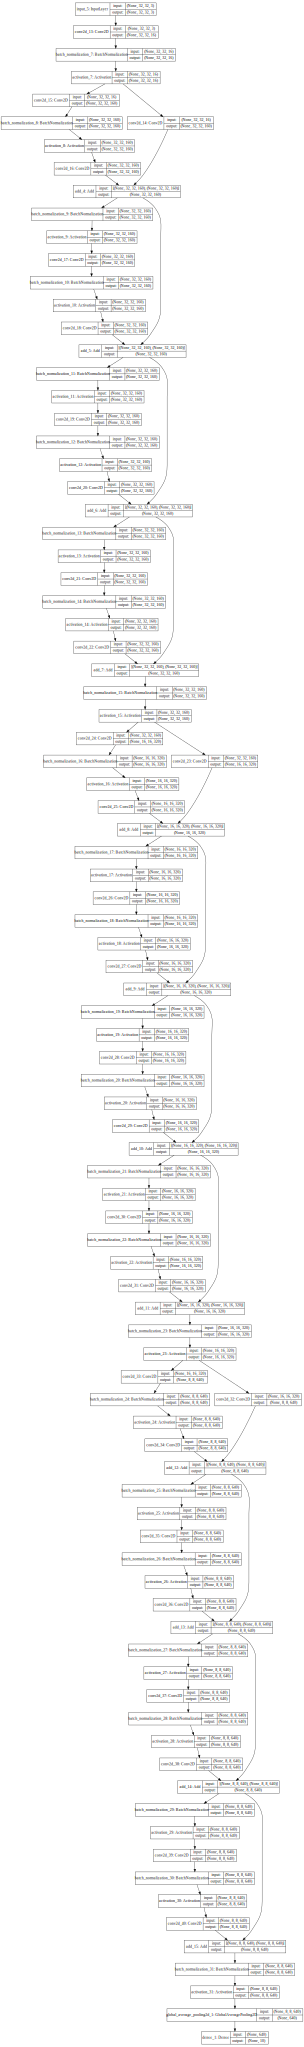

In [11]:
model.summary()
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# model.compile("adam", "categorical_crossentropy", ["accuracy"])
# model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=128, epochs=100)

from keras.preprocessing.image import ImageDataGenerator 
imdgen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 2,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = False,  # randomly flip images
    zoom_range = 0.05,
)
# fit the model on the batches generated by datagen.flow()
dgen = imdgen.flow(training_x, training_y, batch_size=128)
# fmon = keras.callbacks.FitMonitor(thresh=0.03, minacc=0.98)  # this is from our kerutils module (see above)
max_epoch = 100+initial_epoch
h = model.fit_generator(
    dgen,
    steps_per_epoch = training_x.shape[0]//dgen.batch_size,
    epochs = max_epoch,
    initial_epoch = initial_epoch,
    validation_data = (test_x,test_y),
    verbose = 1,
    callbacks = [cpu_percent,hist]
)
initial_epoch = max_epoch

CPU:2.3 memo:30.4
Epoch 1/100
  2/390 [..............................] - ETA: 4:49:50 - loss: 10.3190 - acc: 0.0938